In [1]:
import sys
import os
# Parent directory is in the path
sys.path.append(os.path.abspath("../Models/spacecraft_navigation"))

# Import modules
from SpaceNavigationEnv import SpaceNavigationEnv
from DQN_NN import DQN
from DQN_Agent import DQNAgent
from Plotting import plot_rewards

import numpy as np
import random

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

import gym
from collections import deque

In [2]:
# Training Loop
env = SpaceNavigationEnv()
agent = DQNAgent(env.state_dim, env.action_dim)
rewards = []

episodes = 2000
for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    for time in range(500):  # Max steps per episode
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        rewards.append(reward)
        if done:
            break
    agent.replay()
    agent.update_target_model()
    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

print("Training Complete!")

Episode 1, Total Reward: 372.43402335076485
Episode 2, Total Reward: -855.5552946115466
Episode 3, Total Reward: -276.98169301877743
Episode 4, Total Reward: 177.1595970671832
Episode 5, Total Reward: 102.1148069958
Episode 6, Total Reward: -2546.4335209040837
Episode 7, Total Reward: -2709.245411118152
Episode 8, Total Reward: -926.4289774263034
Episode 9, Total Reward: -1550.8604344697278
Episode 10, Total Reward: -2581.076237539685
Episode 11, Total Reward: -2063.726184872128
Episode 12, Total Reward: -4836.173265856553
Episode 13, Total Reward: -2379.544854417681
Episode 14, Total Reward: -211.82589604807876
Episode 15, Total Reward: -3597.032927736032
Episode 16, Total Reward: -205.5540813659285
Episode 17, Total Reward: -2276.2129237678973
Episode 18, Total Reward: -2725.4829052333253
Episode 19, Total Reward: -348.7572169587049
Episode 20, Total Reward: -1133.4627424612927
Episode 21, Total Reward: -1189.9267924368023
Episode 22, Total Reward: -1344.767328331966
Episode 23, Tota

Note: the results were shown during incremental modifications and testing. The latest results are ran on the current code implementation which is the last cell in this notebook (no need to re-run the other plot cells).

Initial test NN:
```python
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
```

Returns below results:

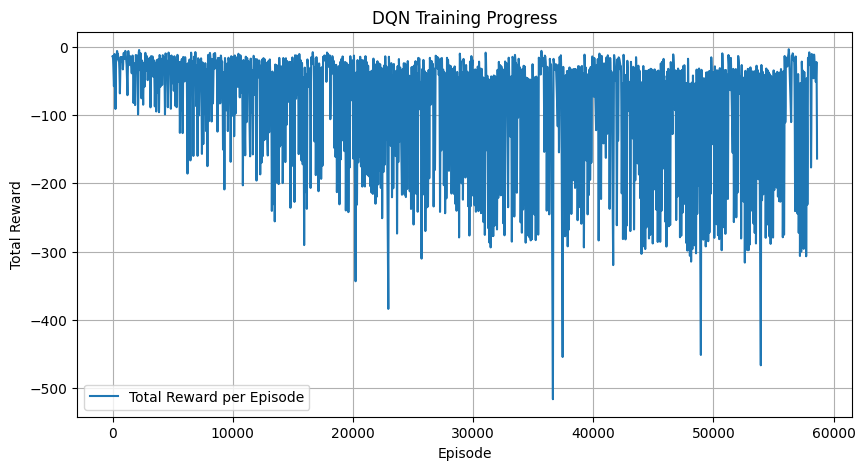

In [15]:
def smooth(y, window_size=50):
    return pd.Series(y).rolling(window=window_size, min_periods=1).mean()

# Plot Total Reward Over Episodes
plt.figure(figsize=(10, 5))
plt.plot(range(len(rewards)), smooth(rewards), label="Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Progress")
plt.legend()
plt.grid()
plt.show()

Updated NN:
```python
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return self.fc5(x)
```

Returns below results:

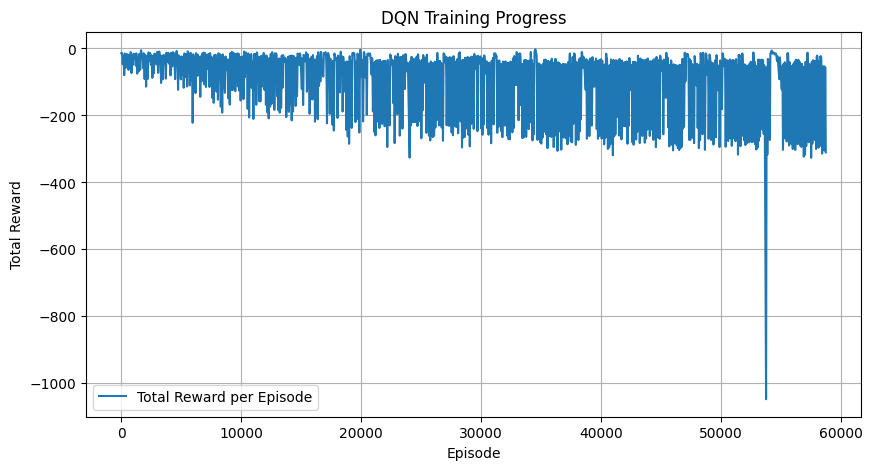

In [3]:
def smooth(y, window_size=50):
    return pd.Series(y).rolling(window=window_size, min_periods=1).mean()

# Plot Total Reward Over Episodes
plt.figure(figsize=(10, 5))
plt.plot(range(len(rewards)), smooth(rewards), label="Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Progress")
plt.legend()
plt.grid()
plt.show()

Updated the reward function in the environment to provide better reward shaping
- A small penalty (-0.1) is applied per step to encourage efficiency.
- The agent gets a scaled reward based on its proximity to the target.
- Running out of fuel results in a significant penalty (-50).

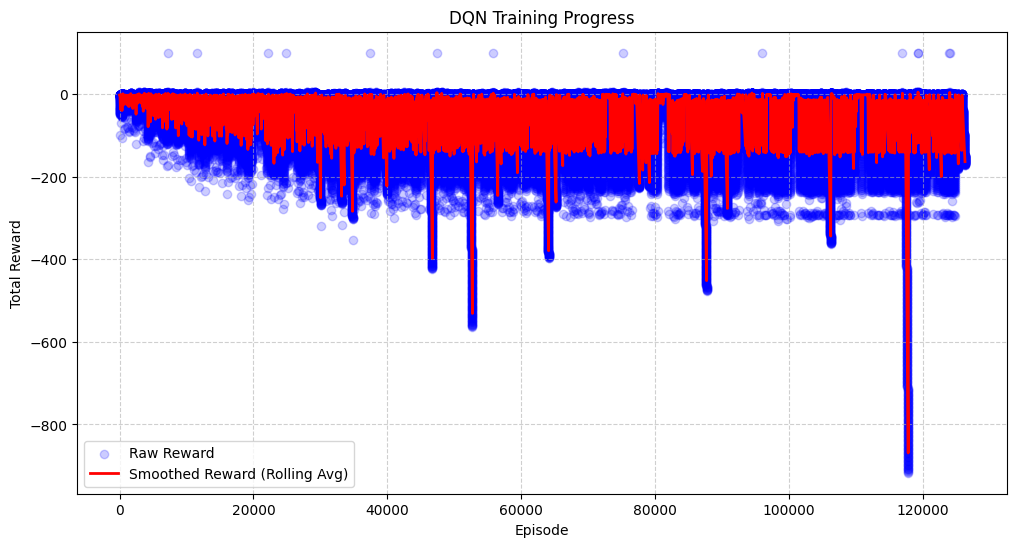

In [6]:
# Implemented improved plotting function
plot_rewards(rewards)

Update the `step` function of the environment:
Adjust Reward Shaping
- The negative reward per step (-0.1) might discourage the agent from exploring.
- Increase the reward for approaching the target faster (+150).
- Introduce a velocity penalty to encourage smooth movements and prevent excessive thrusting.
Improve Done Conditions
- The agent should receive a stronger penalty for excessive fuel use (-75).
- Add a soft boundary condition if the agent strays too far from the target (0.7 * (10.0 - distance)).

Hyperparameter Optimization
Modify Learning Rate
- Current: 0.001 > New: 0.0005 (More stable updates)
Adjust Epsilon Decay
- Current: 0.995 (Explores too long) > New: 0.997 (Slower decay for better long-term learning)
Increase Batch Size
- Current: 32 > New: 64 (More diverse experience replay)

Refined reward shaping
- Lower step penalty (-0.02 instead of -0.05) to encourage exploration.
- Reduced velocity penalties (scaled by distance).
- Lower penalty for fuel depletion (-50 instead of -75).
- Bonus reward (+10) for conserving fuel.

Improved neural network stability
- Batch normalization on first layer.
- Dropout (p=0.1) to prevent overfitting.

Hyperparameter tuning
- Reduced learning rate (0.0003) for smoother updates.
- Added learning rate scheduler (reduces LR every 5000 steps).
- Adaptive epsilon decay (faster initially, slower later).

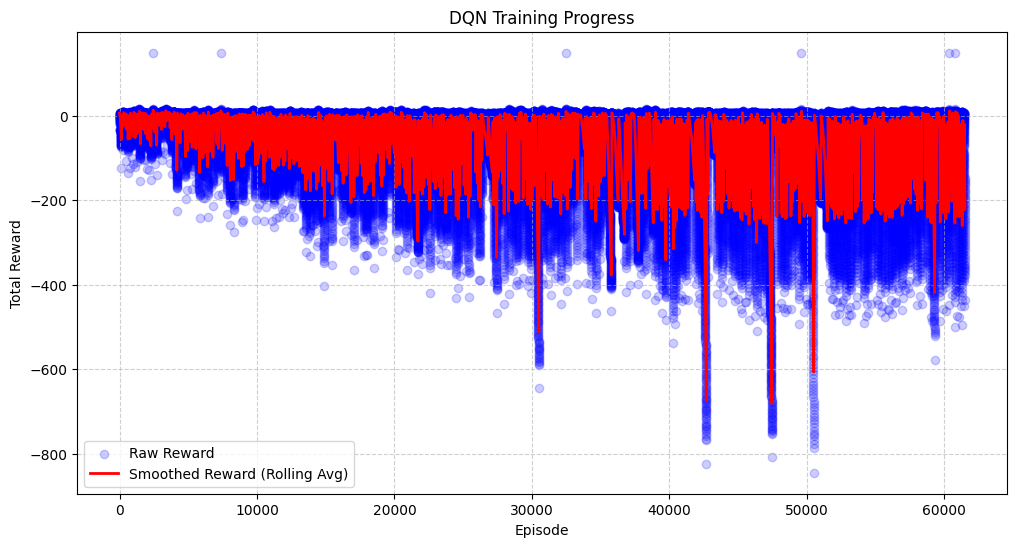

In [5]:
plot_rewards(rewards)

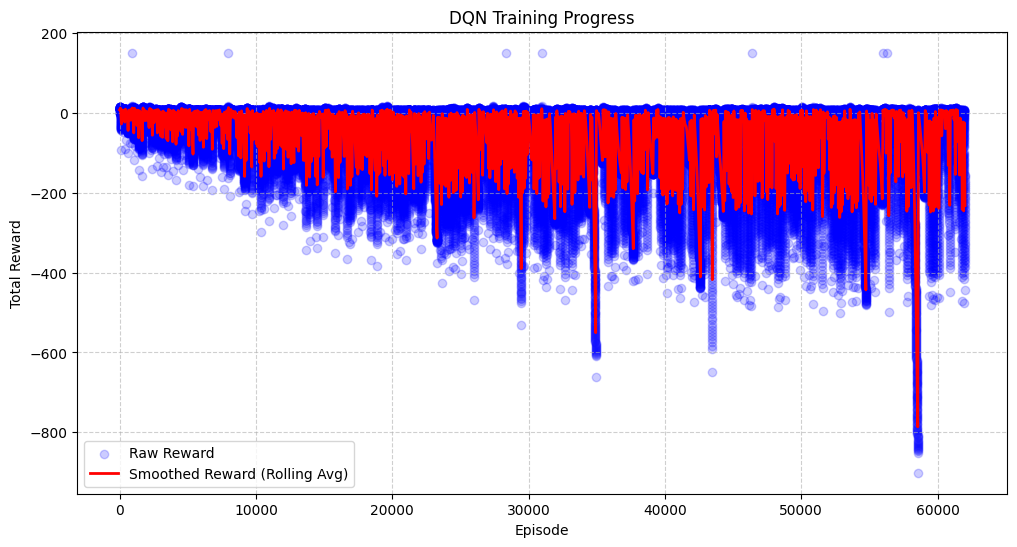

In [3]:
plot_rewards(rewards)

Update to a Dueling DQN:

**From:**
```python
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch normalization
        self.fc2 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.1)  # Dropout layer
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, action_dim
                            
    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        x = torch.relu(self.bn1(self.fc1(x))) if x.shape[0] > 1 else torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return self.fc5(x)
```
**To:**
```python
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        
        # Separate streams for value and advantage
        self.value_stream = nn.Linear(128, 1)
        self.advantage_stream = nn.Linear(128, action_dim)
    
    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)  # Ensure batch dimension exists
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        # Combine value and advantage streams
        q = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q
```

**Update to Prioritized Experience Replay:** Instead of random sampling, importance-weighted sampling is used where rare or high-loss experiences are sampled more often.

- A modified environment with randomized target locations.
- A dueling DQN architecture.
- A prioritized experience replay buffer.
- Reward clipping.
- Gradient clipping.

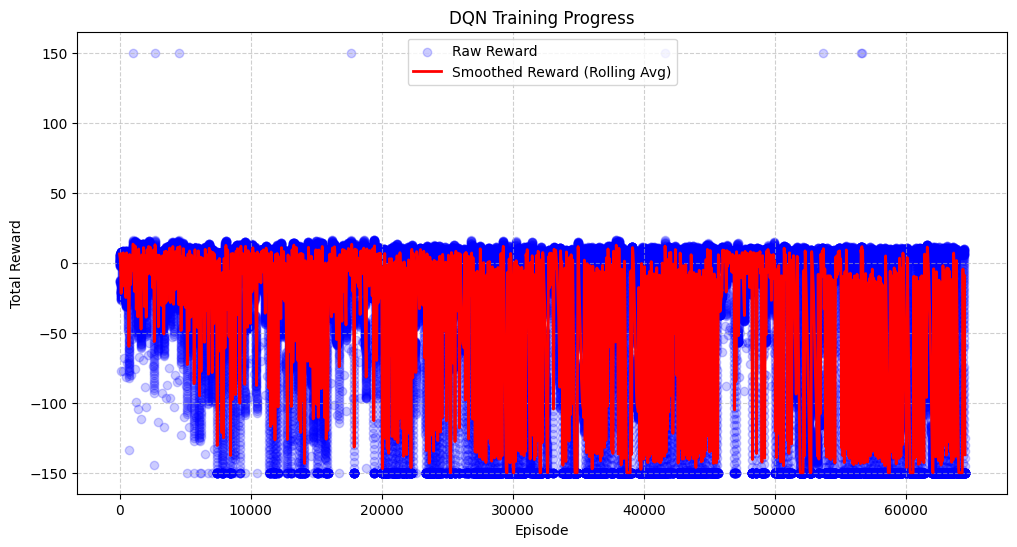

In [3]:
plot_rewards(rewards)

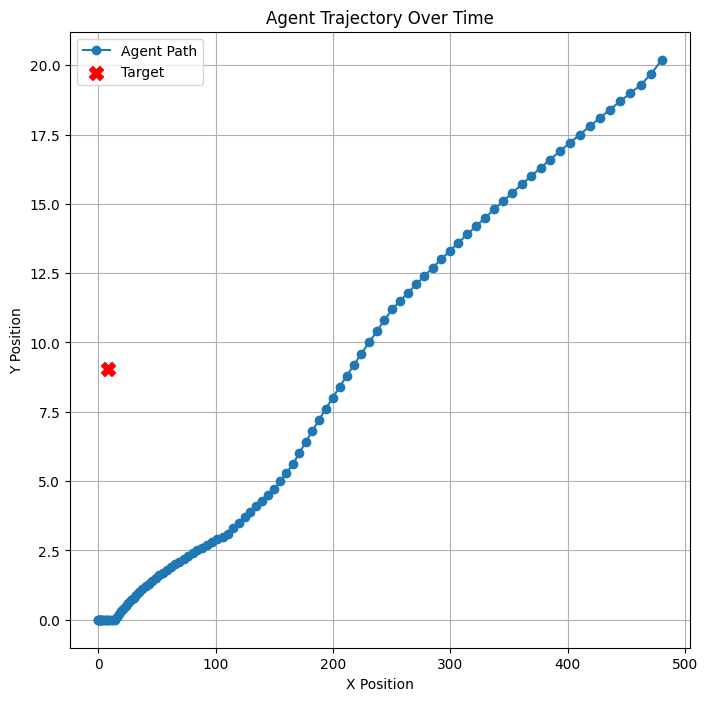

In [15]:
# Check agent trajectory
def plot_trajectory(trajectory, target):
    trajectory = np.array(trajectory)
    plt.figure(figsize=(8, 8))
    plt.plot(trajectory[:, 0], trajectory[:, 1], marker="o", linestyle="-", label="Agent Path")
    plt.scatter([target[0]], [target[1]], color="red", marker="X", s=100, label="Target")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Agent Trajectory Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate a single episode and record the trajectory
state = env.reset()
trajectory = [state.copy()]  # record initial state
done = False

while not done:
    action = agent.act(state)
    state, reward, done, _ = env.step(action)
    trajectory.append(state.copy())

plot_trajectory(trajectory, env.target)